In [2]:
!pip install umap

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3566 sha256=a43f439cb0a56382e9d75da1bf4794d965f0732028d41515a25c5b0d70ff2aad
  Stored in directory: /Users/johanjun/Library/Caches/pip/wheels/d4/13/91/2e752dc8dab5df027854bd33d2b65e1dc5cdc107fd1133990f
Successfully built umap


In [5]:
def format_raw_df(df):
    """
    데이터를 정제하고 질문과 대답을 합칩니다.
    :param df: 원본 DataFrame
    :return: 처리된 DataFrame
    """
    # 타입을 고치고 인덱스를 설정합니다.
    df["PostTypeId"] = df["PostTypeId"].astype(int)
    df["Id"] = df["Id"].astype(int)
    df["AnswerCount"] = df["AnswerCount"].fillna(-1)
    df["AnswerCount"] = df["AnswerCount"].astype(int)
    df["OwnerUserId"].fillna(-1, inplace=True)
    df["OwnerUserId"] = df["OwnerUserId"].astype(int)
    df.set_index("Id", inplace=True, drop=False)

    df["is_question"] = df["PostTypeId"] == 1

    # 문서화된 것 이외의 PostTypeId를 필터링합니다.
    df = df[df["PostTypeId"].isin([1, 2])]

    # 질문과 대답을 연결합니다.
    df = df.join(
        df[["Id", "Title", "body_text", "Score", "AcceptedAnswerId"]],
        on="ParentId",
        how="left",
        rsuffix="_question",
    )
    return df


In [8]:
def get_split_by_author(
    posts, author_id_column="OwnerUserId", test_size=0.3, random_state=40
):
    """
    훈련 세트와 테스트 세트로 나눕니다.
    작성자가 두 세트 중에 하나에만 등장하는 것을 보장합니다.
    :param posts: 모든 포스트와 레이블
    :param author_id_column: author_id가 들어 있는 열 이름
    :param test_size: 테스트 세트로 할당할 비율
    :param random_state: 랜덤 시드
    """
    splitter = GroupShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )
    splits = splitter.split(posts, groups=posts[author_id_column])
    train_idx, test_idx = next(splits)
    return posts.iloc[train_idx, :], posts.iloc[test_idx, :]

In [6]:
import pandas as pd
import spacy
import umap
import numpy as np 
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

# from ml_editor.data_processing import format_raw_df, get_split_by_author
# from ml_editor.data_visualization import plot_embeddings

data_path = Path('./writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

In [7]:
df.head()

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,Tags,Title,ViewCount,body_text,is_question,Id_question,Title_question,body_text_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
1,0,15.0,9,<p>I've always wanted to start writing (in a t...,NaN,7,NaN,2010-11-18T20:40:32.857,17.0,1,...,<resources><first-time-author>,What are some online guides for starting writers?,1274.0,I've always wanted to start writing (in a tota...,True,NaN,NaN,NaN,NaN,NaN
2,1,16.0,7,<p>What kind of story is better suited for eac...,NaN,0,NaN,2010-11-18T20:42:31.513,5.0,2,...,<fiction><grammatical-person><third-person>,What is the difference between writing in the ...,8426.0,What kind of story is better suited for each p...,True,NaN,NaN,NaN,NaN,NaN
3,2,31.0,5,"<p>I finished my novel, and everyone I've talk...",NaN,1,NaN,2010-11-18T20:43:28.903,10.0,3,...,<publishing><novel><agent>,How do I find an agent?,707.0,"I finished my novel, and everyone I've talked ...",True,NaN,NaN,NaN,NaN,NaN
5,3,NaN,7,<p>When writing a short-story to highlight a c...,NaN,0,NaN,2010-11-18T20:43:59.693,4.0,5,...,<plot><short-story><planning><brainstorming>,Decide on a theme/overarching meaning before w...,3132.0,When writing a short-story to highlight a cert...,True,NaN,NaN,NaN,NaN,NaN
7,4,85.0,10,"<p>I keep hearing about literary fiction, and ...",NaN,1,NaN,2010-11-18T20:45:44.067,5.0,7,...,<fiction><genre><categories>,What is Literary Fiction?,795.0,"I keep hearing about literary fiction, and how...",True,NaN,NaN,NaN,NaN,NaN


In [10]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
train_author, test_author = get_split_by_author(df[df["is_question"]])

In [11]:
questions = train_author[train_author["is_question"]]
raw_text = questions["body_text"]

In [13]:
raw_text[:3]

Id
3    I finished my novel, and everyone I've talked ...
5    When writing a short-story to highlight a cert...
7    I keep hearing about literary fiction, and how...
Name: body_text, dtype: object

In [14]:
# 그래프에 컬러로 표시할 레이블을 추출합니다.
# 이 레이블은 분류기를 위한 레이블과 같을 필요는 없습니다.
sent_labels = questions["AcceptedAnswerId"].notna()

sent_labels.value_counts()

True     2907
False    2769
Name: AcceptedAnswerId, dtype: int64

In [15]:
# tfidf 객체를 만듭니다.
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

# 데이터셋에 있는 질문에 적용합니다.
# 벡터화된 배열을 반환합니다.
bag_of_words = vectorizer.fit_transform(raw_text)

bag_of_words.shape

(5676, 27381)

In [19]:
!pip uninstall umap
!pip install umap-learn

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Would remove:
    /Users/johanjun/opt/anaconda3/lib/python3.8/site-packages/umap-0.1.1.dist-info/*
    /Users/johanjun/opt/anaconda3/lib/python3.8/site-packages/umap/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user
  Using cached umap_learn-0.5.1-py3-none-any.whl
     |████████████████████████████████| 1.1 MB 2.6 MB/s eta 0:00:01
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52587 sha256=836d1300ce83e7c06e6b96732cd09f7bd98235e99a0a38059de6e990f3bfef55
  Stored in directory: /Users/johanjun/Library/Caches/pip/wheels/e4/0e/b5/07c0c231aacb04e5d1046fe7459bb27ea79f95b5edbe88e435
Successfully built pynndescent


In [21]:
import umap.umap_ as umap

In [22]:
umap_embedder = umap.UMAP()
umap_bow = umap_embedder.fit_transform(bag_of_words)

In [26]:
from matplotlib.pyplot import Rectangle
def plot_embeddings(embeddings, sent_labels):
    """
    문장 레이블에 따라 색을 입힌 임베딩 그래프 그리기
    :param embeddings: 2차원 임베딩
    :param sent_labels: 출력할 레이블
    """
    fig = plt.figure(figsize=(16, 10))
    color_map = {True: "#1f77b4", False: "#ff7f0e"}
    plt.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        c=[color_map[x] for x in sent_labels],
        s=40,
        alpha=0.4,
    )

    handles = [
        Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ["#1f77b4", "#ff7f0e"]
    ]
    labels = ["answered", "unanswered"]
    plt.legend(handles, labels)

    plt.gca().set_aspect("equal", "box")
    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")

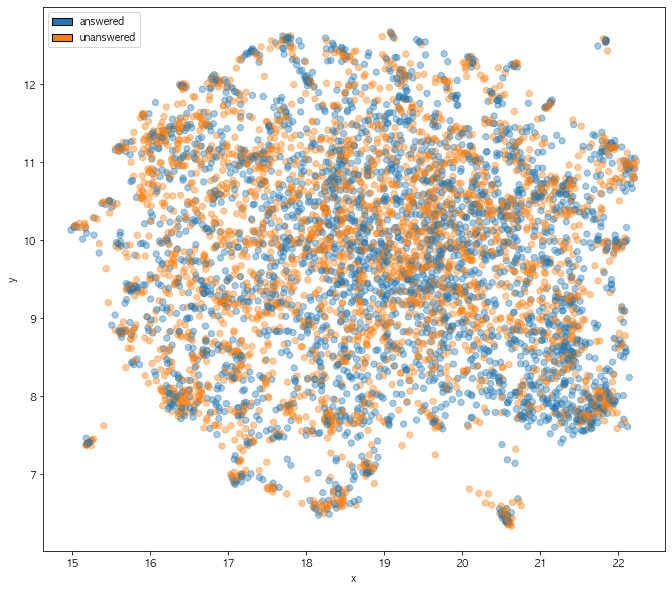

In [27]:
plot_embeddings(umap_bow, sent_labels)

In [28]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 778.8 MB 16 kB/s  eta 0:00:011    |█▏                              | 28.5 MB 11.2 MB/s eta 0:01:08     |████▉                           | 116.8 MB 12.1 MB/s eta 0:00:55     |█████▏                          | 125.3 MB 6.8 MB/s eta 0:01:37     |█████████                       | 217.1 MB 10.1 MB/s eta 0:00:56     |████████████▌                   | 303.6 MB 10.7 MB/s eta 0:00:45     |███████████████                 | 366.8 MB 8.7 MB/s eta 0:00:48     |████████████████▉               | 410.8 MB 28.5 MB/s eta 0:00:13     |██████████████████████████▏     | 636.9 MB 7.1 MB/s eta 0:00:21 MB 122 kB/s eta 0:11:07     |████████████████████████████▊   | 699.1 MB 122 kB/s eta 0:10:49�█████████▏ | 733.3 MB 11.9 MB/s eta 0:00:04
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [29]:
# 라지 모델을 로드하고 이 작업에 불필요한 요소를 제외합니다.
# 이렇게 하면 벡터화 과정의 속도를 크게 높일 수 있습니다.
# 모델에 대한 자세한 내용은 https://spacy.io/models/en#en_core_web_lg 을 참고하세요.
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat", "lemmatizer"])

In [ ]:
# 각 질문에 대한 벡터를 얻습니다.
# 기본적으로 반환된 벡터는 문장에 있는 모든 벡터의 평균입니다.
# 자세한 내용은 https://spacy.io/usage/vectors-similarity 을 참고하세요.
spacy_emb = train_author[train_author["is_question"]]["body_text"].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

In [ ]:
umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

In [ ]:
plot_embeddings(umap_emb, sent_labels)